In [ ]:
# Owais Raza 29637
# Mir Bilal 29638

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import copy
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import statistics
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [8]:
class DataAnalyzer:
    def __init__(self):
        file_path = 'AppliancesEnergyPrediction.csv'

        self.dataset = pd.read_csv(file_path, header=None)
        self.dataset.columns = self.dataset.iloc[0]

        self.dataset = self.dataset.drop(0)
        self.dataset = self.dataset.drop(self.dataset.columns[0], axis=1)
        self.original_dataset = self.dataset
        self.fill_nan_vals()
        # print(self.dataset.shape[1])
        self.dataset = self.dataset.dropna(axis=1)
        # print(self.dataset.shape[1])
        self.convert_to_float()
        self.remove_outliers()
        self.dataset = self.dataset.drop(columns=['lights'])
        self.normalize_df_by_max()

  
    def fill_nan_vals(self):
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Non-numerical column
                mode_val = self.dataset[column].mode()[0]
                self.dataset[column] = self.dataset[column].fillna(mode_val)
            else:  # Numerical column
                mean_val = self.dataset[column].mean()
                self.dataset[column] = self.dataset[column].fillna(mean_val)

    def drop_nan_vals(self):
        self.dataset = self.dataset.dropna()
        
    def convert_to_float(self):
        for column in self.dataset.columns:
            self.dataset.loc[:, column] = self.dataset[column].astype(float)


    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=4, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        for col in self.dataset.columns:
            q1 = self.dataset[col].quantile(0.25)
            q3 = self.dataset[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            self.dataset = self.dataset[(self.dataset[col] >= lower_bound) & (self.dataset[col] <= upper_bound)]
        return self.dataset

    def normalize_df_by_max(self):
        columns_to_exclude=[]
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns:
            if column not in columns_to_exclude:
                max_abs_value = abs(self.dataset[column]).max()
                normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return self.dataset

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test_final = sc.transform(self.X_test_final)
        if self.X_cv is not None:
            self.X_cv = sc.fit_transform(self.X_cv)
        return(self.X_train, self.X_test_final, self.X_cv)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self, dataset = None):
        if dataset is None:
            corr_matrix = self.dataset.corr()
        else:
            corr_matrix = dataset.corr()
        plt.figure(figsize=(20, 20))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def perform_filter_methods(self):
        data = copy.deepcopy(self.dataset)
        X = copy.deepcopy(data).drop(columns=['Appliances'])  # Features
        print("total features = ", len(X.columns))
        y = copy.deepcopy(data['Appliances']).astype(float) 
        # Calculate Mutual Information scores
        mi_scores = mutual_info_regression(X, y)
        # Select features with MI score > 0.5
        selected_features = X.columns[mi_scores > 0.05]
        print(mi_scores)
        print("selected features with high mutual information with the target = ", len(selected_features))
        # Calculate correlation matrix
        corr_matrix = X[selected_features].corr().abs()
        copy_ds = copy.deepcopy(data[selected_features])
        # Remove one of two highly correlated features
        to_drop = set()
        dropped_columns = {}
        for i in range(len(corr_matrix.columns)):
            if i not in dropped_columns:
                for j in range(len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.8 and i!=j and j not in dropped_columns and i not in dropped_columns and i!=j:
                        
                        colname_i = corr_matrix.columns[i]
                        colname_j = corr_matrix.columns[j]
                        # Calculate the Mutual Information score of each feature with the target variable
                        mi_i = mutual_info_regression(X[colname_i].values.reshape(-1, 1), y)[0]
                        mi_j = mutual_info_regression(X[colname_j].values.reshape(-1, 1), y)[0]
                        # Keep the feature with higher Mutual Information score
                        if mi_i > mi_j:
                            to_drop.add(colname_j)
                            dropped_columns[j] = colname_j
                        else:
                            to_drop.add(colname_i)
                            dropped_columns[i] = colname_i
        final_selected_features = selected_features.drop(to_drop)
        print("final selected features after removing one of two correlated features = ", len(final_selected_features))
        self.dataset = self.dataset[final_selected_features]
        self.dataset["Appliances"] = data["Appliances"]
        self.show_heat_map()
        return self.dataset
    
    def perform_wrapper_method(self):
        feature_scores = []
        feature_scores_dict = {}
        total_num_of_columns = len(self.X.columns)
        for i in range(1,total_num_of_columns+1):
            newAnlyzr = DataAnalyzer()
            newAnlyzr.get_x_and_Y()
            (best_avg_score, scores) = newAnlyzr.perform_kfold_cv(num_of_columns=i)
            mean_score = newAnlyzr.get_accuracy()
            feature_scores.append((i, mean_score))
            feature_scores_dict[i] = mean_score
        self.feature_scores = feature_scores
        additional_feature_penalty = -0.05
        score_weight = 0.95
        adjusted_scores = []
        best_num_of_features = 1
        best_adjusted_score = 0
        for (j, mn_score) in feature_scores:
            adjusted_score = mn_score*score_weight + j*additional_feature_penalty/total_num_of_columns
            adjusted_scores.append((j, adjusted_score))
            if adjusted_score > best_adjusted_score:
                best_adjusted_score = adjusted_score
                best_num_of_features = j
        best_score = feature_scores_dict[best_num_of_features]

        return {
            "best_num_of_features": best_num_of_features,
            "best_score": best_score
        }
    
    def plot_wrapper_scores(self):
        x_values, y_values = zip(*self.feature_scores)
        # Create a Plotly trace
        trace = go.Scatter(x=x_values, y=y_values, mode='lines+markers')

        # Create a Plotly layout
        layout = go.Layout(
            title='Wrapper Method Feature Scores',
            xaxis=dict(title='Number of Features'),
            yaxis=dict(title='Accuracy')
        )

        # Create a Plotly figure
        fig = go.Figure(data=[trace], layout=layout)

        # Display the plot
        fig.show()

    def perform_pca(self, n_components=None):
        # Standardize the data
        scaler = StandardScaler()
        data = self.X
        standardized_data = scaler.fit_transform(data)

        # Create PCA object
        pca = PCA(n_components=n_components)

        # Fit and transform the data
        pca_data = pca.fit_transform(standardized_data)

        # Create a DataFrame for the PCA results
        pca_columns = [f"PC{i+1}" for i in range(pca_data.shape[1])]
        pca_df = pd.DataFrame(data=pca_data, columns=pca_columns)

        # Concatenate with original dataset
        self.X = pca_df

    def plot_variations(self):
        min_max_scaler = preprocessing.MinMaxScaler()
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['Appliances']
        # x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    
    def get_x_and_Y(self):
        self.X = self.dataset.drop('Appliances', axis=1)  # Assuming 'p' is the target variable
        self.y = self.dataset['Appliances']
        return (self.X, self.y)
    
    def perform_manual_splitting_cv(self):
        # First split to get training set and first test set
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(self.X, self.y, test_size=0.4, random_state=0)
        self.y_train = self.y_train.astype(float)
        y_temp =  y_temp.astype(float)

        # Second split to further split the temporary test set into the second test set
        self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
        self.y_cv = self.y_cv.astype(float)
        self.y_test_final = self.y_test_final.astype(float)

    def perform_manual_splitting_without_cv(self):
        # First split to get training set and first test set
        self.X_train, self.X_test_final, y_train, y_temp = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        self.y_train = y_train.astype(float)
        self.y_test_final = y_temp.astype(float)

    def perform_knn_without_cv(self):
        self.classifier = KNeighborsRegressor(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_test_final)
        rmse = mean_squared_error(self.y_test_final,y_pred1)  # Calculate RMSE
        target_range = np.max(self.y) - np.min(self.y)  # Calculate the range of the target variable
        accuracy_percentage = (1 - (rmse / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage
        return self.ac_final
        

    def perform_knn(self):
        self.classifier = KNeighborsRegressor(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_cv)
        self.ac_cv = mean_squared_error(self.y_cv,y_pred1)
        return self.ac_cv

    def get_accuracy(self):
        y_pred_final = self.classifier.predict(self.X_test_final)
        # self.ac_final = mean_squared_error(self.y_test_final,y_pred_final)
        rmse = mean_squared_error(self.y_test_final,y_pred_final)  # Calculate RMSE
        target_range = np.max(self.y) - np.min(self.y)  # Calculate the range of the target variable
        accuracy_percentage = (1 - (rmse / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage
        return self.ac_final

    
    def perform_kfold_cv(self, num_of_columns = None):
        X_train, X_test_final, y_train, y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        if num_of_columns:
            X_train = copy.deepcopy(X_train.iloc[:, :num_of_columns])
            X_test_final = copy.deepcopy(X_test_final.iloc[:, :num_of_columns])
        self.X_train = X_train
        self.y_train = y_train.astype(float)
        self.X_test_final = X_test_final.reindex(X_train.columns, axis=1)
        self.y_test_final = y_test_final.astype(float)
        classifier = KNeighborsRegressor(n_neighbors = 40, metric = 'minkowski', p = 2.7)

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=0)

        scores = []
        best_model = None
        best_score = 0

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index].astype(float), y_train.iloc[val_index].astype(float)

            # Train the model on the training fold
            classifier.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the validation fold
            y_val_pred = classifier.predict(X_val_fold)
            rmse = mean_squared_error(y_val_fold, y_val_pred)
            target_range = np.max(self.y) - np.min(self.y)  # Calculate the range of the target variable
            accuracy_percentage = (1 - (rmse / target_range)) * 100  # Calculate accuracy as a percentage

            # Update the best model if the current model has a better average performance
            if accuracy_percentage > best_score:
                best_score = accuracy_percentage
                best_model = classifier
            scores.append(accuracy_percentage)
        
        self.classifier = best_model
        return(best_score, scores)

class Master:
    def __init__(self):
        self.results = {}
        
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_without_cv(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_without_cv()
        rslts = anlyzr.perform_knn_without_cv()
        self.results["run without cv"] = rslts

    def run_with_cv(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["run with cv"] = anlyzr.get_accuracy()

    def run_with_kfold(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        (best_avg_score, scores) = anlyzr.perform_kfold_cv()
        self.results["after_k_fold_run"] = {
            "best kfold cv score": best_avg_score,
            "scores": scores,
            "final kfold score on test dataset": anlyzr.get_accuracy()
        }

    def run_with_filter(self):
        # Implement feature selection using filter method (e.g., correlation)
        anlyzr = DataAnalyzer()
        anlyzr.perform_filter_methods()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["with_filter_method"] = anlyzr.get_accuracy()

    def run_with_wrapper(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        self.results = anlyzr.perform_wrapper_method()
        anlyzr.plot_wrapper_scores()

    def run_with_pca(self):
        # Implement feature selection using PCA
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_pca(n_components=2)
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["with_pca"] = anlyzr.get_accuracy()

    def run_with_ols(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()

        anlyzr.X_train = anlyzr.X_train.astype(float)
        anlyzr.y_train = anlyzr.y_train.astype(float)
        #add constant to predictor variables
        x = sm.add_constant(anlyzr.X_train)

        #fit linear regression model
        model = sm.OLS(anlyzr.y_train, anlyzr.X_train).fit()
        print(model.summary())
        y_cv_pred = model.predict(anlyzr.X_cv)

        mse_cv = mean_squared_error(anlyzr.y_cv, y_cv_pred)
        r2 = r2_score(anlyzr.y_cv, y_cv_pred)

        target_range = np.max(anlyzr.y) - np.min(anlyzr.y)  # Calculate the range of the target variable
        accuracy_percentage_cv = (1 - (mse_cv / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage_cv

        # 
        y_test_pred = model.predict(anlyzr.X_test_final)

        mse_test = mean_squared_error(anlyzr.y_test_final, y_test_pred)
        r2 = r2_score(anlyzr.y_test_final, y_test_pred)

        accuracy_percentage_test = (1 - (mse_test / target_range)) * 100  # Calculate accuracy as a percentage
        self.ac_final = accuracy_percentage_test

        self.results["run_with_ols_cv"] = accuracy_percentage_cv
        self.results["run_with_ols_test"] = accuracy_percentage_test
    
    def run_cv_problem(self):
        self.run_without_cv()
        self.run_with_cv()
        self.run_with_kfold()
        return self.results


In [9]:
ols_mstr = Master()
ols_mstr.run_with_ols()
ols_mstr.organize_results()

                                 OLS Regression Results                                
Dep. Variable:             Appliances   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              2204.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):                        0.00
Time:                        17:39:27   Log-Likelihood:                          4074.7
No. Observations:                6063   AIC:                                     -8099.
Df Residuals:                    6038   BIC:                                     -7932.
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

,method,result
0,run_with_ols_cv,98.322561
1,run_with_ols_test,98.372363


In [120]:
cv_mstr = Master()
cv_mstr.run_cv_problem()
cv_mstr.organize_results()

run without cv 98.05054283397335
run with cv 98.17919339471693
after_k_fold_run {'best kfold cv score': 98.41556267393321, 'scores': [98.0949561642839, 98.26141976677035, 98.41556267393321, 98.20092014078358, 97.96462378171411], 'final kfold score on test dataset': 97.94317846064612}


,method,result
0,run without cv,98.050543
1,run with cv,98.179193
2,best kfold cv score,98.415563
3,scores,"[98.0949561642839, 98.26141976677035, 98.41556..."
4,final kfold score on test dataset,97.943178


total features =  26
[0.11321647 0.05698162 0.08019683 0.06700778 0.08466134 0.08625785
 0.10191847 0.09208195 0.11395698 0.07870649 0.08700356 0.11230406
 0.12919327 0.0839117  0.1212191  0.09080678 0.12871963 0.08247214
 0.07155805 0.09064286 0.05131616 0.01721836 0.02553596 0.04183593
 0.00315677 0.00315677]
selected features with high mutual information with the target =  21
final selected features after removing one of two correlated features =  9


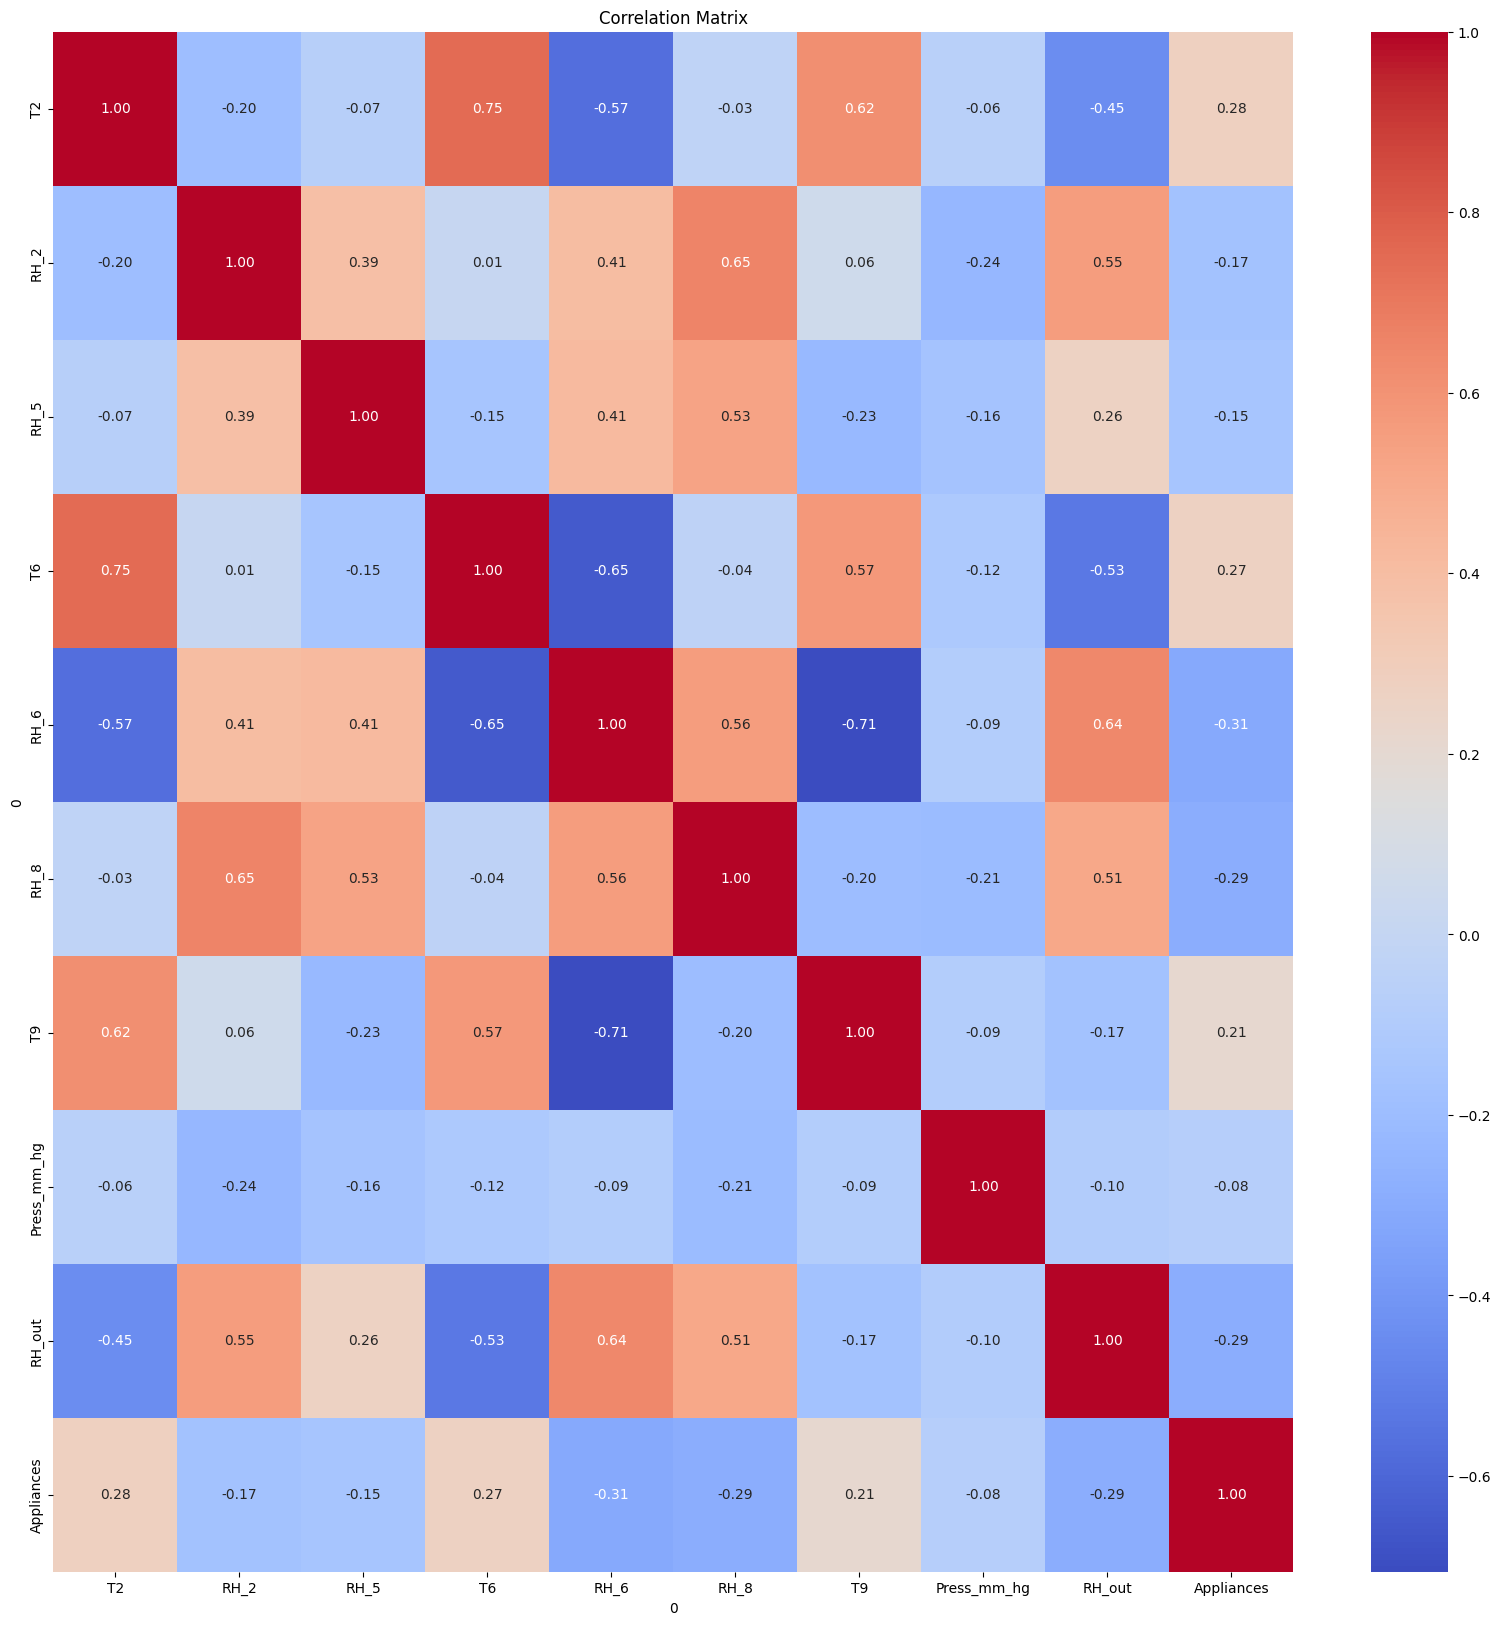

with_filter_method 98.44539841159016


,method,result
0,with_filter_method,98.445398


In [125]:
filter_mstr = Master()
filter_mstr.run_with_filter()
filter_mstr.organize_results()

In [122]:
wrapper_mstr = Master()
wrapper_mstr.run_with_wrapper()
wrapper_mstr.organize_results()

best_num_of_features 17
best_score 98.29398627960086


,method,result
0,best_num_of_features,17.000000
1,best_score,98.293986


In [123]:
pca_mstr = Master()
pca_mstr.run_with_pca()
pca_mstr.organize_results()

with_pca 98.1187089078955


,method,result
0,with_pca,98.118709
